In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import eigvalsh, eigh

import algo
import utils
import interactions
import dicke

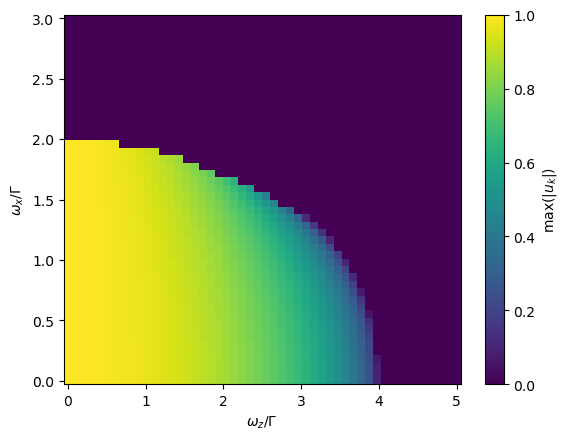

In [29]:
N = 10
beta = 10
wzs = np.linspace(0, 5, 50)
wxs = np.linspace(0, 3, 50)
alpha = 0.3
M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

us = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        uks1 = minimize(dicke.uks_f, x0=np.array([0.0]*len(ws)), args=(beta, wz, ws, np.sqrt(N) * lams, gs, N)).x
        uks2 = minimize(dicke.uks_f, x0=np.array([2.0]*len(ws)), args=(beta, wz, ws, np.sqrt(N) * lams, gs, N)).x
        
        if dicke.uks_f(uks1, beta, wz, ws, np.sqrt(N) * lams, gs, N) < dicke.uks_f(uks2, beta, wz, ws, np.sqrt(N) * lams, gs, N):
            uks = uks1
        else:
            uks = uks2
            
        us[i, j] = np.amax(np.abs(uks))


plt.pcolormesh(wzs, wxs, us.T, cmap='viridis')
plt.colorbar(label=r'$\max(|u_k|)$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

In [45]:
def kernel(xs, λs, gs):
    return 2*np.sum(λs*xs, axis=1) + gs

def mags_f(uks, beta, wz, λs, gs):
    aux = kernel(uks, λs, gs)
    return 0.5 * np.tanh(0.5 * beta * np.sqrt(wz**2 + 4*aux**2)) * 4 * aux / np.sqrt(wz**2 + 4*aux**2)

def secnd_order_line(wz):
    return np.sqrt((4 * wz**2)**(2/3) - wz**2)

/var/folders/54/wwvz2d1s1v7ck12y_l10q3pw0000gn/T/ipykernel_90243/3448075039.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((4 * wz**2)**(2/3) - wz**2)


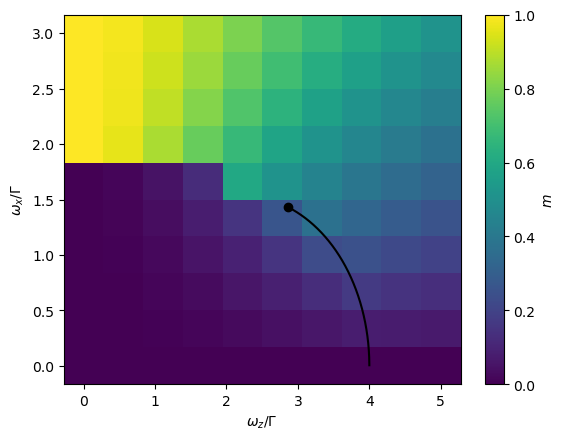

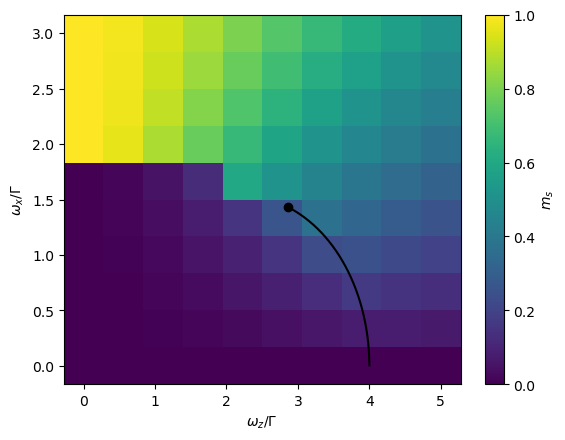

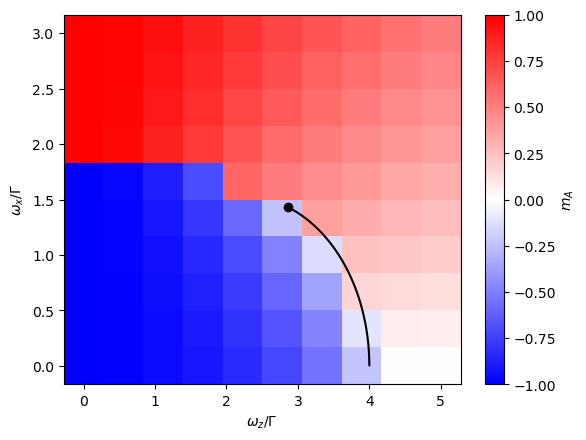

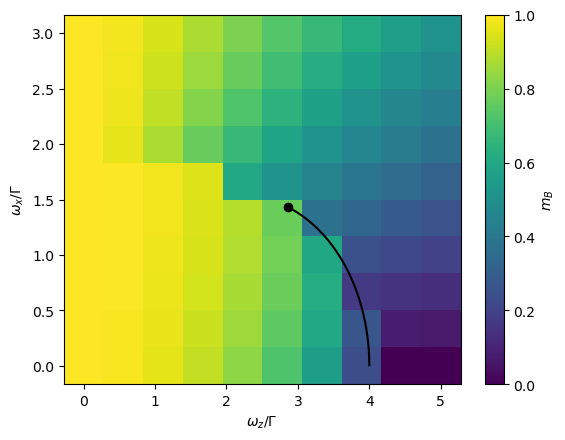

In [56]:

N = 10
beta = 10
wzs = np.linspace(0, 5, 10)
wxs = np.linspace(0, 3, 10)
alpha = 0.3
M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

v_stagger = np.ones(N)
v_stagger[1::2] = 1

mag = np.empty((len(wzs), len(wxs)))
stmag = np.empty((len(wzs), len(wxs)))
magA = np.empty((len(wzs), len(wxs)))
magB = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        uks1 = minimize(dicke.uks_f, x0=np.array([0.0]*len(ws)), args=(beta, wz, ws, np.sqrt(N) * lams, gs, N)).x
        uks2 = minimize(dicke.uks_f, x0=np.array([2.0]*len(ws)), args=(beta, wz, ws, np.sqrt(N) * lams, gs, N)).x
        
        if dicke.uks_f(uks1, beta, wz, ws, np.sqrt(N) * lams, gs, N) < dicke.uks_f(uks2, beta, wz, ws, np.sqrt(N) * lams, gs, N):
            uks = uks1
        else:
            uks = uks2
            
        mags = mags_f(uks, beta, wz, np.sqrt(N) * lams, gs)
        
        mag[i, j] = np.sum(mags) / N
        stmag[i, j] = np.sum(mags * v_stagger) / N
        magA[i, j] = np.sum(mags[::2]) * 2 / N
        magB[i, j] = np.sum(mags[1::2]) * 2 / N

supercritical_pt = 4 * (4/5)**(3/2)
wzs_dense = np.linspace(supercritical_pt, 4, 100000)

plt.pcolormesh(wzs, wxs, mag.T, cmap='viridis')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, stmag.T, cmap='viridis')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, magA.T, cmap='bwr')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m_A$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, magB.T, cmap='viridis')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m_B$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()